# Revisando el contenido de la Propuesta de nueva constitución

Este análisis está inspirado en el trabajo realizado en el ramo de Procesamiento de Lenguaje Natural.
La idea es entender los principales temas de cada capítulo de la constitución y si estos coinciden con los títulos de cada uno de ellos.

## Importando librerías

In [1]:
import pandas as pd
import numpy as np
import string
from nltk import word_tokenize
import re

In [2]:
import os

In [3]:
import networkx as nx

In [4]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt
from matplotlib.pyplot import text
import seaborn as sns

In [5]:
from collections import Counter

In [6]:
import spacy
nlp = spacy.load('es_core_news_sm')

In [7]:
import warnings
warnings.filterwarnings("ignore")

## Funciones

In [8]:
def delete_stopwords(text):
    """
    Función para eliminar stopwords del texto
    """
    doc = nlp(text)
    return ' '.join([word.text for word in doc if word.text not in esp_stop])

In [9]:
def cleaner(df, text):
    """
    Función para dejar las palabras en minúscula, eliminar números, puntuación, espacios y saltos de línea.
    """
    df[text] = df[text].str.lower()
    df[text] = df[text].apply(lambda x: re.sub("[0-9]", '', str(x)))
    df[text] = df[text].str.translate(str.maketrans(' ', ' ', string.punctuation))
    df[text] = df[text].str.replace('\n',' ')
    df[text] = df[text].str.strip()
    return df[text]

In [10]:
def wordcloud(data):
    """
    Función para graficar un wordcloud
    """
    wc = WordCloud(background_color='white',width=800, height=400, max_words=200, colormap = 'plasma').generate_from_frequencies(data)
    plt.figure(figsize=(15, 10))
    plt.imshow(wc, interpolation='bilinear')
    plt.axis('off')
    plt.show()

## Desarrollo

In [11]:
from nltk.corpus import stopwords
esp_stop = stopwords.words('spanish')
esp_stop = esp_stop + ['ser','tener','deber']

## Llevando texto a dataframe

### Cargando markdowns

In [12]:
# Get the list of all files and directories
path = "Markdown/"
filelist = os.listdir(path)

In [13]:
filelist.sort()

In [14]:
filelist

['.ipynb_checkpoints',
 '00.md',
 '01.md',
 '02.md',
 '03.md',
 '04.md',
 '05.md',
 '06.md',
 '07.md',
 '08.md',
 '09.md',
 '10.md',
 '11.md',
 '12.md',
 '13.md']

In [15]:
df_constitucion = pd.DataFrame()
texto_total = ''

for file in filelist[1:]:
    with open(path+file, 'r', encoding = 'utf-8') as f:
        text = f.read()
        if text[-1:] != '\n':
            text = text+'\n'
    
    texto_total = texto_total + text

serie = texto_total.split('\n')

### Llevando a dataframe

In [16]:
df = pd.DataFrame({'texto':serie})

df['capitulo'] = np.where(df['texto'].str.contains('# Preámbulo'),df['texto'],np.nan)
df['capitulo'] = np.where(df['texto'].str.contains('# Disposiciones Transitorias'),df['texto'],df['capitulo'])
df['capitulo'] = np.where(df['texto'].str.contains('# Convención Constitucional'),df['texto'],df['capitulo'])
df['capitulo'] = np.where(df['texto'].str.contains('Capítulo'),df['texto'],df['capitulo'])

#Para asegurar que aparezca el capitulo IV
df['capitulo'] = np.where(df['texto'].str.contains('Capitulo'),df['texto'],df['capitulo'])
df['articulo'] = np.where(df['texto'].str.contains('### Artículo'),df['texto'],np.nan)
df['texto'] = np.where(df['texto']=='', np.nan, df['texto'])
df['texto'] = np.where(df['texto']==df['articulo'], np.nan, df['texto'])
df['texto'] = np.where(df['texto']==df['capitulo'], np.nan, df['texto'])
# Agregar numeral y ordinal (??)


df['capitulo'].fillna(method='pad', inplace=True)
df['articulo'].fillna(method='pad', inplace=True)


In [17]:
df.dropna(subset = 'texto', inplace = True)

In [18]:
df['nro_capitulo'] = df['capitulo'].str.split(':', expand = True)[0]
df['nro_capitulo'] = df['nro_capitulo'].str.replace('# ','')
df['titulo_capitulo'] = df['capitulo'].str.split(':', expand = True)[1]
df['titulo_capitulo'] = df['titulo_capitulo'].str.strip()
df['articulo'] = df['articulo'].str.replace('### ','')

df['articulo'] = np.where(df['nro_capitulo']=='Convención Constitucional',np.nan,df['articulo'])
df['titulo_capitulo'] = np.where(df['titulo_capitulo'].isna(), df['nro_capitulo'], df['titulo_capitulo'])

In [19]:
df = df[['nro_capitulo','titulo_capitulo','articulo','texto']]
df.rename(columns = {'nro_capitulo':'capitulo'}, inplace = True)

In [20]:
df['q_palabras'] = df['texto'].apply(lambda x: len(x.split()))

In [21]:
df

,capitulo,titulo_capitulo,articulo,texto,q_palabras
2,Preámbulo,Preámbulo,NaN,"Nosotras y nosotros, el pueblo de Chile, confo...",24
7,Capítulo I,Principios y Disposiciones Generales,Artículo 1,1. Chile es un Estado social y democrático de ...,16
8,Capítulo I,Principios y Disposiciones Generales,Artículo 1,2. Se constituye como una república solidaria....,37
9,Capítulo I,Principios y Disposiciones Generales,Artículo 1,3. La protección y garantía de los derechos hu...,62
13,Capítulo I,Principios y Disposiciones Generales,Artículo 2,"1. La soberanía reside en el pueblo de Chile, ...",36
...,...,...,...,...,...
3188,Convención Constitucional,Convención Constitucional,NaN,Carolina Vilches Fuenzalida,3
3190,Convención Constitucional,Convención Constitucional,NaN,Ingrid Villena Narbona,3
3192,Convención Constitucional,Convención Constitucional,NaN,Manuel Woldarsky González,3
3194,Convención Constitucional,Convención Constitucional,NaN,Camila Zárate Zárate,3


## Limpieza

In [22]:
df['texto'] = cleaner(df, 'texto')

In [23]:
df['q_palabras'] = df['texto'].apply(lambda x: len(x.split()))

<AxesSubplot:xlabel='q_palabras', ylabel='Density'>

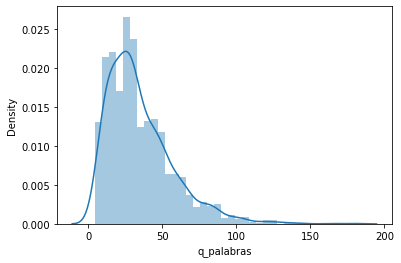

In [24]:
sns.distplot(df[df['q_palabras']>4]['q_palabras'])

In [25]:
capitulos = list(df['capitulo'].value_counts().index)

In [26]:
orden = [
        'Preámbulo',
        'Principios y Disposiciones Generales',
        'Derechos Fundamentales y Garantías',
        'Naturaleza y Medioambiente',
        'Participación Democrática',
        'Buen Gobierno y Función Pública',
        'Estado Regional y Organización Territorial',
        'Poder Legislativo',
        'Poder Ejecutivo',
        'Sistemas de Justicia',
        'Órganos Autónomos Constitucionales',
        'Reforma y Reemplazo de la Constitución',
        'Disposiciones Transitorias'
    ]

## Gráficos

### ¿Qué tan largo es cada capítulo de la propuesta de constitución?

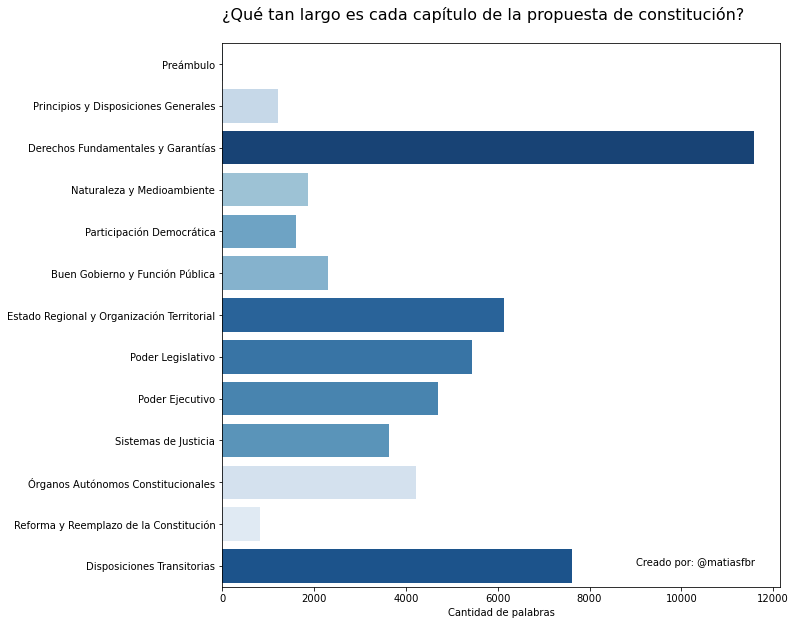

In [27]:
fig, ax = plt.subplots(1,1, figsize = (10,10))

aux = df.groupby(['capitulo','titulo_capitulo'], dropna = False)['q_palabras'].sum().reset_index()
data = pd.Series(data = dict(zip(aux['titulo_capitulo'],aux['q_palabras'])), index = aux['titulo_capitulo'])
pal = sns.color_palette("Blues", len(data))
rank = data.argsort().argsort()

sns.barplot(
    y =  data.index,
    x = data,
    order = orden,
    palette = np.array(pal[:])[rank],
    estimator = np.sum, 
    ax = ax
)


ax.set_title(
    '¿Qué tan largo es cada capítulo de la propuesta de constitución?\n',
    x = 0,
    y = 1,
    fontsize = 16,
    ha = 'left',
    va = 'baseline'
)

ax.set_ylabel('')
ax.set_xlabel('Cantidad de palabras')
ax.annotate(xy = (0,0), text = 'Creado por: @matiasfbr', xytext = (9000,12));

### ¿Cuán dispersos son los parrafos por capítulo?

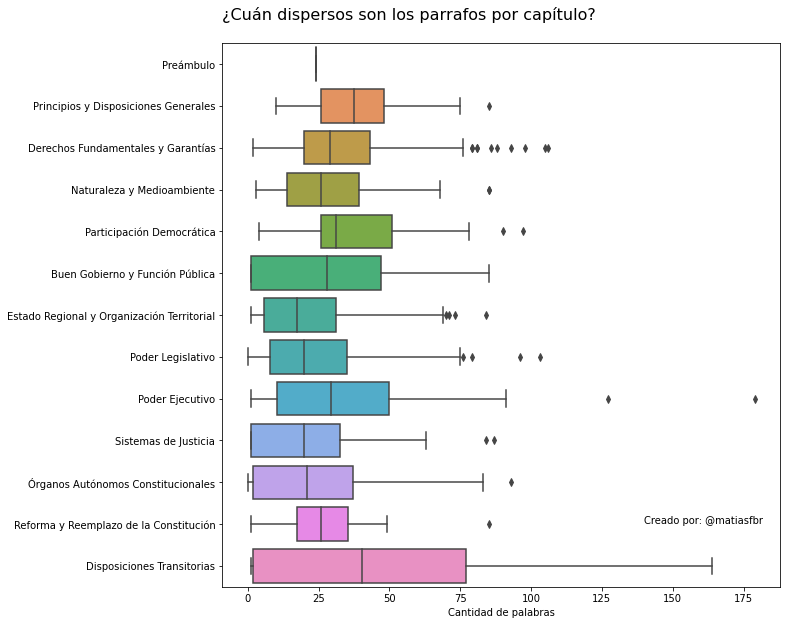

In [28]:
fig, ax = plt.subplots(1,1, figsize = (10,10))

sns.boxplot(
    data = df,
    y = 'titulo_capitulo',
    x = 'q_palabras',
    order = orden,
    ax = ax
)


ax.set_title(
    '¿Cuán dispersos son los parrafos por capítulo?\n',
    x = 0,
    y = 1,
    fontsize = 16,
    ha = 'left',
    va = 'baseline'
)

ax.set_ylabel('')
ax.set_xlabel('Cantidad de palabras')
ax.annotate(xy = (0,0), text = 'Creado por: @matiasfbr', xytext = (140,11));

## Wordclouds con trigramas

### Texto completo

In [29]:
corpus_token = [word_tokenize(texto) for texto in df.texto]

texto_trigrama = []

for lista in corpus_token:
    for i, palabra in enumerate(lista):
        if i < len(lista)-2:
            texto_trigrama.append(lista[i] + ' ' + lista[i+1] + ' ' + lista[i+2])
            
dict_counter = Counter(texto_trigrama)

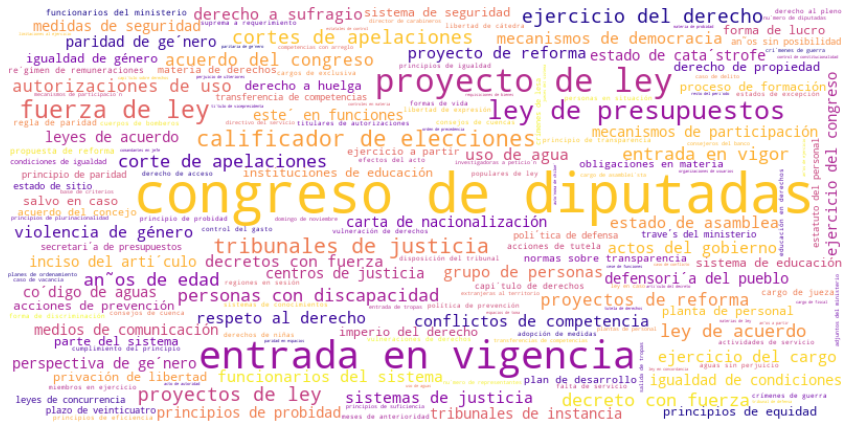

In [30]:
tags = []

for i in list(dict_counter.keys()):
    doc = nlp(i)
    tag = [token.tag_ for token in doc]
    tags.append(tag)
    
grams = dict(zip(dict_counter.keys(), tags))

lista = []
for k, v in grams.items():
    if v == ['NOUN','ADP','NOUN']:
        lista.append(k)
        
dict_token = {}

for i in dict_counter.items():
    if i[0] in lista:
        dict_token.update({i[0]:i[1]})
        
wordcloud(dict_token)

Ordenando el diccionario de trigramas de mayor a menor

In [31]:
trigramas_sorted = {k: v for k, v in sorted(dict_token.items(), key=lambda item: item[1], reverse = True)}

Obteniendo el top10 de trigramas que más aparecen en el documento

In [32]:
top_trigramas = []
n = 10

for i,v in enumerate(trigramas_sorted.items()):
    if i < n:
        top_trigramas.append(v)

Por lo tanto el top 10 de conceptos más recurrentes dentro del texto es:

In [33]:
top_trigramas

[('congreso de diputadas', 87),
 ('entrada en vigencia', 38),
 ('proyecto de ley', 25),
 ('ley de presupuestos', 16),
 ('fuerza de ley', 13),
 ('calificador de elecciones', 11),
 ('tribunales de justicia', 10),
 ('cortes de apelaciones', 8),
 ('proyectos de ley', 8),
 ('ejercicio del derecho', 8)]

Rescatando el trigrama, para poder buscarlo dentro de cada parrafo

In [58]:
trigramas = []

for i in top_trigramas:
    trigramas.append(i[0])

Recorriendo el trigrama para ver si contiene cada uno de los 10 conceptos seleccionados

In [59]:
for i in trigramas:
    df[i] = np.where(df['texto'].str.contains(i), 1, 0)

Separamos la información y la agrupamos por capitulo

In [60]:
df_stream = df.groupby(['capitulo','titulo_capitulo'])[
    'congreso de diputadas',
    'entrada en vigencia', 
    'proyecto de ley',
    'ley de presupuestos', 
    'fuerza de ley',
    'calificador de elecciones',
    'tribunales de justicia', 
    'cortes de apelaciones', 
    'proyectos de ley',
    'ejercicio del derecho'
].sum()


Quitando el capítulo de la Convención Constitucional

In [61]:
df_stream.drop(index = 'Convención Constitucional', inplace = True)

In [62]:
df_stream = df_stream.reset_index()

In [63]:
df_stream['proyectos de ley'] = df_stream[['proyecto de ley','proyectos de ley']].sum(axis = 1)
df_stream.drop(columns = 'proyecto de ley', inplace = True)

Quitando proyecto de ley del trigrama, ya que juntamos todo en proyectos de ley

In [64]:
trigramas.remove('proyecto de ley')
trigramas

['congreso de diputadas',
 'entrada en vigencia',
 'ley de presupuestos',
 'fuerza de ley',
 'calificador de elecciones',
 'tribunales de justicia',
 'cortes de apelaciones',
 'proyectos de ley',
 'ejercicio del derecho']

In [65]:
capitulos = [
        'Preámbulo',
        'Principios y Disposiciones Generales',
        'Derechos Fundamentales y Garantías',
        'Naturaleza y Medioambiente',
        'Participación Democrática',
        'Buen Gobierno y Función Pública',
        'Estado Regional y Organización Territorial',
        'Poder Legislativo',
        'Poder Ejecutivo',
        'Sistemas de Justicia',
        'Órganos Autónomos Constitucionales',
        'Reforma y Reemplazo de la Constitución',
        'Disposiciones Transitorias'
    ]

ocurrencias_por_tema = {}

for i in trigramas:
    data = {i:list(df_stream[i].values)}
    ocurrencias_por_tema.update(data)

Definiendo la paleta de colores

In [66]:
pal = sns.color_palette("tab20c", len(capitulos))

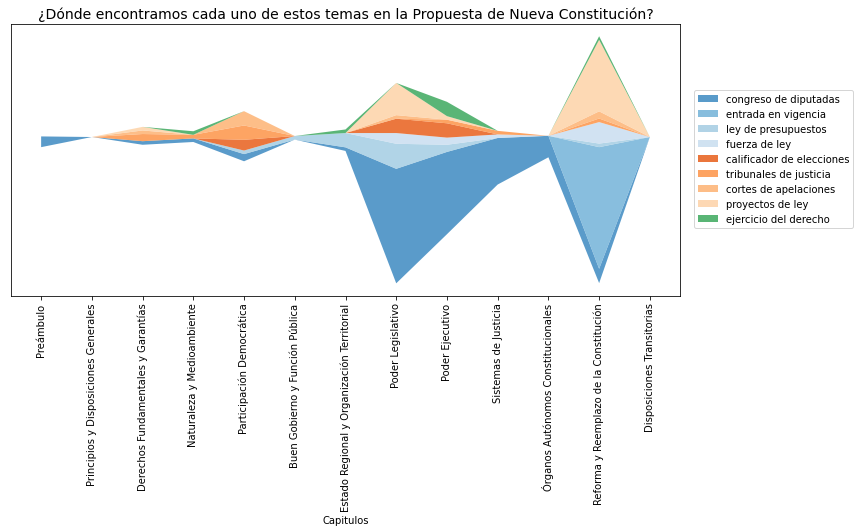

In [67]:
fig, ax = plt.subplots(1,1, figsize = (12,5))
ax.stackplot(
    capitulos,
    ocurrencias_por_tema.values(),
    labels=ocurrencias_por_tema.keys(),
    baseline = 'wiggle',
    alpha=0.8,
    colors = pal

)

ax.legend(loc=(1.02,0.25))
ax.set_xticklabels(capitulos, rotation = 90)
ax.set_title(
    '¿Dónde encontramos cada uno de estos temas en la Propuesta de Nueva Constitución?',
    fontsize = 14
)
ax.set_xlabel('Capitulos')
ax.set_ylabel('Cantidad de veces que aparece')
ax.get_yaxis().set_visible(False)
plt.show()

In [77]:
sum_total = df_stream.iloc[:,2:].sum(axis = 1).sum()

In [79]:
trigramas

['congreso de diputadas',
 'entrada en vigencia',
 'ley de presupuestos',
 'fuerza de ley',
 'calificador de elecciones',
 'tribunales de justicia',
 'cortes de apelaciones',
 'proyectos de ley',
 'ejercicio del derecho']

In [81]:
for i in trigramas:
    df_stream[i] = df_stream[i]/sum_total

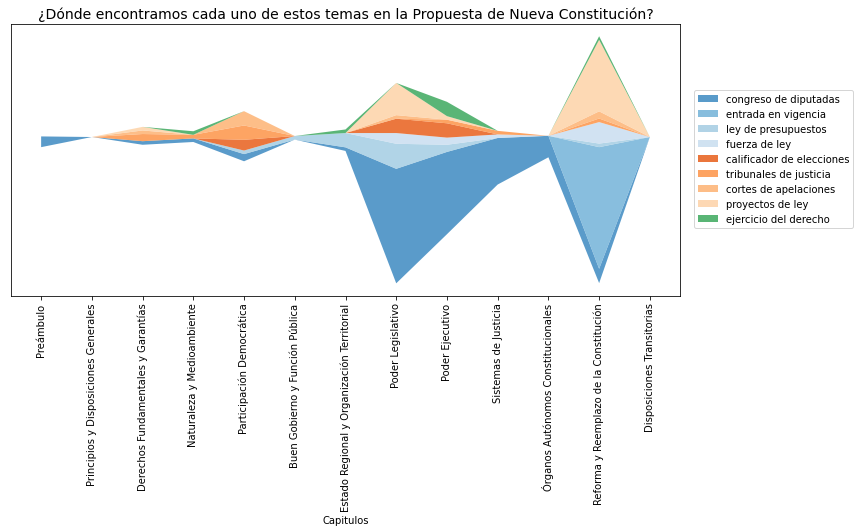

In [85]:
capitulos = [
        'Preámbulo',
        'Principios y Disposiciones Generales',
        'Derechos Fundamentales y Garantías',
        'Naturaleza y Medioambiente',
        'Participación Democrática',
        'Buen Gobierno y Función Pública',
        'Estado Regional y Organización Territorial',
        'Poder Legislativo',
        'Poder Ejecutivo',
        'Sistemas de Justicia',
        'Órganos Autónomos Constitucionales',
        'Reforma y Reemplazo de la Constitución',
        'Disposiciones Transitorias'
    ]

ocurrencias_por_tema = {}

for i in trigramas:
    data = {i:list(df_stream[i].values)}
    ocurrencias_por_tema.update(data)
    
fig, ax = plt.subplots(1,1, figsize = (12,5))
ax.stackplot(
    capitulos,
    ocurrencias_por_tema.values(),
    labels=ocurrencias_por_tema.keys(),
    baseline = 'wiggle',
    alpha=0.8,
    colors = pal

)

ax.legend(loc=(1.02,0.25))
ax.set_xticklabels(capitulos, rotation = 90)
ax.set_title(
    '¿Dónde encontramos cada uno de estos temas en la Propuesta de Nueva Constitución?',
    fontsize = 14
)
ax.set_xlabel('Capitulos')
ax.set_ylabel('Cantidad de veces que aparece')
ax.get_yaxis().set_visible(False)
plt.show()

In [82]:
df_stream

,capitulo,titulo_capitulo,congreso de diputadas,entrada en vigencia,ley de presupuestos,fuerza de ley,calificador de elecciones,tribunales de justicia,cortes de apelaciones,proyectos de ley,ejercicio del derecho
0,Capitulo IV,Participación Democrática,0.013953,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
1,Capítulo I,Principios y Disposiciones Generales,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2,Capítulo II,Derechos Fundamentales y Garantías,0.004651,0.00000,0.000000,0.000000,0.000000,0.009302,0.004651,0.004651,0.000000
3,Capítulo III,Naturaleza y Medioambiente,0.004651,0.00000,0.000000,0.000000,0.000000,0.004651,0.000000,0.000000,0.004651
4,Capítulo IX,Sistemas de Justicia,0.009302,0.00000,0.004651,0.000000,0.013953,0.018605,0.018605,0.000000,0.000000
5,Capítulo V,Buen Gobierno y Función Pública,0.000000,0.00000,0.004651,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
6,Capítulo VI,Estado Regional y Organización Territorial,0.004651,0.00000,0.018605,0.000000,0.000000,0.000000,0.000000,0.000000,0.004651
7,Capítulo VII,Poder Legislativo,0.148837,0.00000,0.032558,0.013953,0.018605,0.000000,0.004651,0.041860,0.000000
8,Capítulo VIII,Poder Ejecutivo,0.106977,0.00000,0.009302,0.009302,0.018605,0.004651,0.000000,0.004651,0.018605
9,Capítulo X,Órganos Autónomos Constitucionales,0.060465,0.00000,0.000000,0.004651,0.000000,0.004651,0.000000,0.000000,0.000000
